In [715]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader
import torch.distributions as dists
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import math
import random
import matplotlib.pyplot as plt


In [716]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
setup_seed(1142)

In [717]:
class CNN_VectorQuantizer(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. 
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # initialize embeddings
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        
    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        x = x.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if not self.training:
            quantized = quantized.permute(0, 3, 1, 2).contiguous()
            return quantized,encoding_indices
        
        # embedding loss: move the embeddings towards the encoder's output
        q_latent_loss = F.mse_loss(quantized, x.detach())
        # commitment loss
        e_latent_loss = F.mse_loss(x, quantized.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, loss
    
    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings.weight ** 2, dim=1) -
            2. * torch.matmul(flat_x, self.embeddings.weight.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return self.embeddings(encoding_indices)  

class CNN_Encoder(nn.Module):
    """Encoder of VQ-VAE"""
    
    def __init__(self, in_dim=3, latent_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, latent_dim, 1),
        )
        
    def forward(self, x):
        return self.convs(x)
    

class CNN_Decoder(nn.Module):
    """Decoder of VQ-VAE"""
    
    def __init__(self, out_dim=1, latent_dim=16):
        super().__init__()
        self.out_dim = out_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, out_dim, 3, padding=1),
        )
        
    def forward(self, x):
        return self.convs(x)

class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, embedding_dim, num_embeddings, data_variance, 
                 commitment_cost=0.25):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = CNN_Encoder(in_dim, embedding_dim)
        self.vq_layer = CNN_VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)
        self.decoder = CNN_Decoder(in_dim, embedding_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e,enco = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon,enco
        
        e, e_q_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x) / self.data_variance
        
        return e_q_loss , recon_loss ,F.mse_loss(x_recon, x)   

In [718]:
epochs=10
batch_size = 256
embedding_dim = 16
num_embeddings = 128

In [719]:
print('Load DataSet....')
transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.MNIST('/data/liumingxuan/SNN-VAE-DMSVDD/datasets/Datasets', train=True, download=True,
                        transform=transform)
dataset2 = datasets.MNIST('/data/liumingxuan/SNN-VAE-DMSVDD/datasets/Datasets', train=False,
                        transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)
print('done!')

Load DataSet....
done!


In [720]:
print('prepare vq-vae....')
train_images = []
for images, labels in train_loader:
    train_images.append(images)
train_images = torch.cat(train_images, dim=0)
train_data_variance = torch.var(train_images)
model = VQVAE(1, embedding_dim, num_embeddings, train_data_variance)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images - 0.5 # normalize to [-0.5, 0.5]
        images = images.cuda()
        loss_eq,loss_rec,real_loss_rec = model(images)
        loss = loss_eq+loss_rec
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch {} Loss {:.3f} Loss_eq {:.3f} Loss_rec {:.3f}".format(epoch, loss, loss_eq, real_loss_rec))

prepare vq-vae....
Epoch 0 Loss 0.586 Loss_eq 0.405 Loss_rec 0.017
Epoch 1 Loss 0.547 Loss_eq 0.434 Loss_rec 0.011
Epoch 2 Loss 0.419 Loss_eq 0.317 Loss_rec 0.010
Epoch 3 Loss 0.328 Loss_eq 0.242 Loss_rec 0.008
Epoch 4 Loss 0.296 Loss_eq 0.220 Loss_rec 0.007
Epoch 5 Loss 0.281 Loss_eq 0.211 Loss_rec 0.007
Epoch 6 Loss 0.282 Loss_eq 0.209 Loss_rec 0.007
Epoch 7 Loss 0.270 Loss_eq 0.202 Loss_rec 0.006
Epoch 8 Loss 0.253 Loss_eq 0.190 Loss_rec 0.006
Epoch 9 Loss 0.249 Loss_eq 0.189 Loss_rec 0.006


test vq-vae....


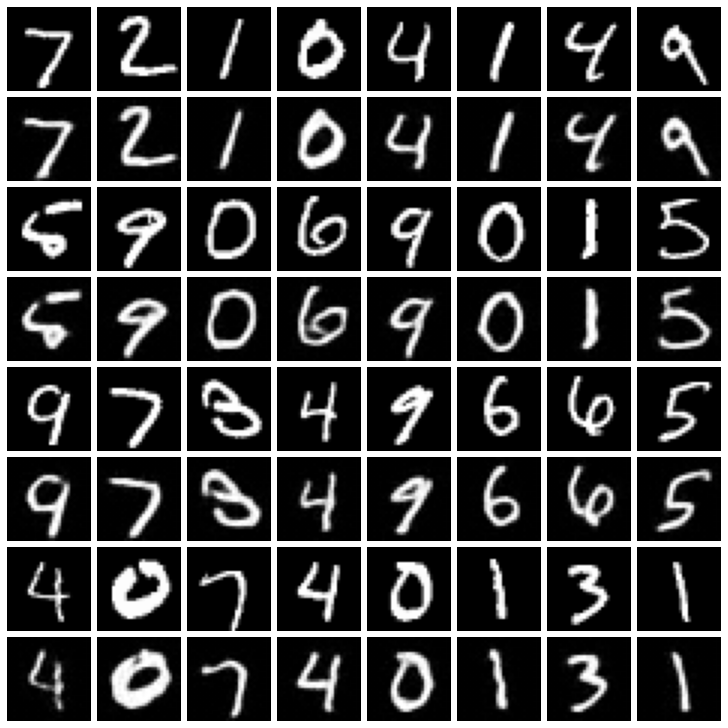

In [721]:
print('test vq-vae....')
# reconstructe images

test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)

n_samples = 32
images = images[:n_samples]

model.eval()

norm_images = (images - 0.5).cuda()
with torch.inference_mode():
    e, recon_images,_ = model(norm_images)

recon_images = np.array(np.clip((recon_images + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
ori_images = np.array(images.numpy() * 255, dtype=np.uint8)

recon_images = recon_images.reshape(4, 8, 28, 28)
ori_images = ori_images.reshape(4, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row * 2, n_col])
        f_ax.imshow(ori_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")
        f_ax = fig.add_subplot(gs[n_row * 2 + 1, n_col])
        f_ax.imshow(recon_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [722]:
print('prepare data for train diffusion...')
train_indices = []
for images, labels in train_loader:
    images = images - 0.5 # normalize to [-0.5, 0.5]
    images = images.cuda()
    with torch.inference_mode():
        _,_,encoding_indices = model(images) # [B, C, H, W, T]
        train_indices.append(encoding_indices.reshape(images.shape[0],7,7).cpu())
print(len(train_indices))

prepare data for train diffusion...
235


In [723]:
print((train_indices[0][100]))
mask_id, index = torch.mode(train_indices[0][100])
mask_id = mask_id[0]
mask_id = 0
print("mask_id =" ,mask_id)

tensor([[119, 119, 119, 119, 119, 119, 119],
        [119, 119, 119,  70,  35,  58, 113],
        [119, 119,  70,  22,  44,  76, 113],
        [119,  20,  35, 110,  70,  76, 119],
        [119,  67,  63,  20,  35, 110, 119],
        [119,  67, 114,  22,  51, 119, 119],
        [119, 113,  90,  97, 119, 119, 119]])
mask_id = 0


In [724]:
print('data for train diffusion is ready!')

data for train diffusion is ready!


In [725]:
class AbsorbingDiffusion():

    # H：存放超参数
    # denoise_fn：逆扩散模型，即为一个Transformer模型
    # mask_id：决定mask掉的位置使用哪个参数
    # embedding_weight：vq_vae中embedding层内部的参数
    # aux_weight——暂时不知道
    def __init__(self, denoise_fn, mask_id):
        super().__init__()

        # 类别数量——即codebook的size数量——128
        self.num_classes = 128

        # latent的shape，7x7
        self.shape = [7,7]

        # 时间步数量
        self.num_timesteps = 256

        # mask掉的位置用什么填充
        self.mask_id = mask_id

        # 去噪模型
        self._denoise_fn = denoise_fn

        # 一次采样输出的数量
        self.n_samples = 64


    def sample_time(self, b, device):
        # 这里应该是每次训练都从各种程度的噪声中进行采样
        # 那么从1到num_timesteps之间随机整数采样b个时间步长t
        t = torch.randint(1, self.num_timesteps+1, (b,), device=device).long()

        # 将pt设置为一个全1的张量，除以num_timesteps，表示每个时间步长有相同的概率
        pt = torch.ones_like(t).float() / self.num_timesteps
        return t, pt

    # 它的作用是采样q(x_t | x_0)，即给定x_0的条件下，x_t的概率分布。x_t是加入了噪声和掩码的x_0
    def q_sample(self, x_0, t):
        # samples q(x_t | x_0)
        # randomly set token to mask with probability t/T

        # 输入是原始矩阵x_0和时间t，首先copy一下输入x_t
        x_t, x_0_ignore = x_0.clone(), x_0.clone()
        #print(x_t.shape)
        #print(t.shape)
        # 生成一个与x_t形状相同的随机张量mask，它的元素是0或1，表示是否要掩码某个位置。掩码的概率与t成正比，即t越大，掩码越多
        # 当t最大时mask取全1，这个是一个均匀扩散过程
        t_mask = t.reshape(x_0.shape[0], 1, 1,1)
        t_mask = t_mask.expand(x_0.shape[0], 1, 7, 7)
        
        mask = torch.rand_like(x_t.float()) < (t_mask.float() / self.num_timesteps)

        # 将x_t中mask为1的位置替换为self.mask_id，这是一个特殊的标识符，表示该位置被掩码了。
        x_t[mask] = self.mask_id

        # 将x_0_ignore中mask为0的位置替换为-1，这是一个忽略索引，表示该位置不参与损失计算
        x_0_ignore[torch.bitwise_not(mask)] = -1
        return x_t, x_0_ignore, mask

    # 训练损失如何得到
    # 输入编码矩阵x_0
    def _train_loss(self, x_0):

        # b-batch_size
        b, device = x_0.size(0), x_0.device
        
        # choose what time steps to compute loss at
        # 得到本次训练的时间与每个时间出现的概率，这里每个时间出现的概率相等
        t, pt = self.sample_time(b, device)

        # make x noisy and denoise
        # 输入x_0与t得到掩码噪声后的结果
        x_t, x_0_ignore, mask = self.q_sample(x_0=x_0, t=t)

        # sample p(x_0 | x_t)
        # 调用_denoise_fn函数，对x_t进行去噪，得到x_0_hat_logits，即x_0的预测概率分布
        x_0_hat_logits = self._denoise_fn(x_t, t=t)

        # Always compute ELBO for comparison purposes
        # x_0_ignore(256,1,7,7)
        # x_0_hat_logits(258,128,7,7)
        # 调用F.cross_entropy函数，使用x_0_hat_logits和x_0_ignore计算交叉熵损失，忽略索引为-1的位置，得到每个样本的损失之和cross_entropy_loss
        cross_entropy_loss = F.cross_entropy(x_0_hat_logits.reshape(b,128,49), x_0_ignore.reshape(b,49).type(torch.LongTensor).cuda(), ignore_index=-1, reduction='none').sum(1)
        
        # 计算变分下界vb_loss，即将cross_entropy_loss除以t和pt，并除以log(2)乘以x_0的元素数量。这是为了估计p(x_0)的下界。
        vb_loss = cross_entropy_loss / t
        vb_loss = vb_loss / pt
        vb_loss = vb_loss / (math.log(2) * x_0.shape[1:].numel())

        # 根据loss_type的值，选择不同的损失函数
        loss = vb_loss

        return loss.mean()

    def sample(self, temp=1.0, sample_steps=None):
        b, device = self.n_samples, 'cuda'
        x_t = torch.ones(b,1,7,7, device=device).long() * self.mask_id

        unmasked = torch.zeros_like(x_t, device=device).bool()
        
        sample_steps = list(range(1, sample_steps+1))

        for t in reversed(sample_steps):
            print(f'Sample timestep {t:4d}', end='\r')
            t = torch.full((b,), t, device=device, dtype=torch.long)

            # where to unmask
            # TODO: 随着时间步长的增长 降低已经被回复过的像素的再被回复的概率
            t_mask = t.reshape(b, 1, 1,1)
            t_mask = t_mask.expand(b, 1, 7, 7)
            #print(t_mask.shape)
            #print(x_t.shape)
            changes = torch.rand_like(x_t.float()) < 1/t_mask.float()
            changes = changes.cuda()
            #print(changes.shape)
            # don't unmask somewhere already unmasked
            changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
            # update mask with changes
            unmasked = torch.bitwise_or(unmasked, changes)

            x_0_logits = self._denoise_fn(x_t.float(), t=t)
            #print(x_0_logits.shape)

            # scale by temperature
            x_0_logits = x_0_logits / temp
            index = torch.argmax(x_0_logits, dim=1)
            x_0_hat = index.unsqueeze(1)

            #print(x_0_hat.shape)

            x_t.long()[changes] = x_0_hat.long()[changes]

        return x_t

    def train_iter(self, x):
        loss = self._train_loss(x)
        stats = {'loss': loss}
        return stats

In [730]:
blk = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 3, 1, 1),
    nn.BatchNorm2d(oc),
    nn.LeakyReLU(),
)

class DummyModel(nn.Module):
    """
    This should be transformer, but let's don't think about the model too much :P
    Basically, any universal R^n -> R^n model should work.
    """
    # batch_size 1 7 7 
    # batch_size  1287 7
    # batch_size 1 7 7 
    def __init__(self, n_channel: int) -> None:
        super(DummyModel, self).__init__()
        self.conv = nn.Sequential(  # with batchnorm
            blk(n_channel, 64),
            blk(64,128),
            blk(128, 256),
            blk(256, 512),
            blk(512, 256),
            blk(256, 256),
            nn.Conv2d(256, 128, 3, 1,1),
        )

    def forward(self, x, t) -> torch.Tensor:
        # Lets think about using t later. In the paper, they used Tr-like positional embeddings.
        return self.conv(x)


In [731]:
denoise_fn = DummyModel(1).cuda()
abdiff = AbsorbingDiffusion(denoise_fn, mask_id=mask_id)

Epoch 0  Loss 2.055
Epoch 1  Loss 1.907
Epoch 2  Loss 1.734
Epoch 3  Loss 1.613
Epoch 4  Loss 2.034
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


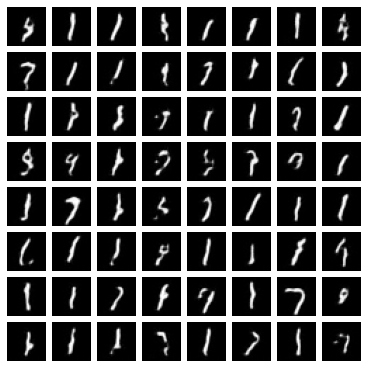

Epoch 5  Loss 1.704
Epoch 6  Loss 1.625
Epoch 7  Loss 1.564
Epoch 8  Loss 1.582
Epoch 9  Loss 1.669
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


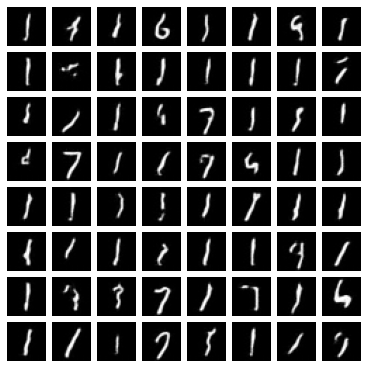

Epoch 10  Loss 1.497
Epoch 11  Loss 1.489
Epoch 12  Loss 1.621
Epoch 13  Loss 1.492
Epoch 14  Loss 1.801
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


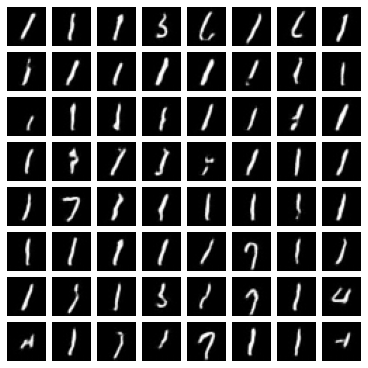

Epoch 15  Loss 1.532
Epoch 16  Loss 1.563
Epoch 17  Loss 1.511
Epoch 18  Loss 1.540
Epoch 19  Loss 1.514
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


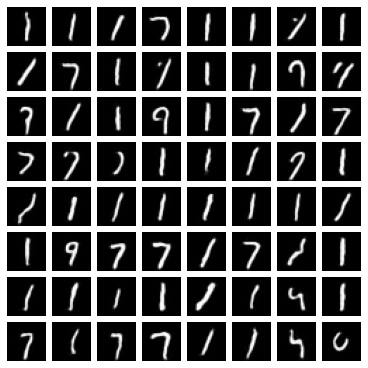

Epoch 20  Loss 1.448
Epoch 21  Loss 1.580
Epoch 22  Loss 1.494
Epoch 23  Loss 1.394
Epoch 24  Loss 1.550
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


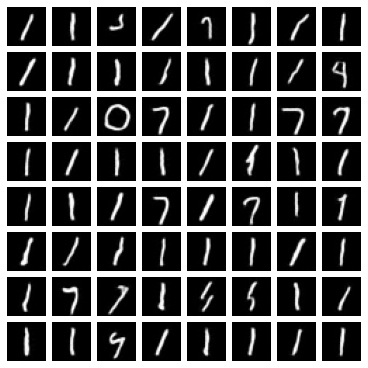

Epoch 25  Loss 1.521
Epoch 26  Loss 1.387
Epoch 27  Loss 1.406
Epoch 28  Loss 1.347
Epoch 29  Loss 1.373
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


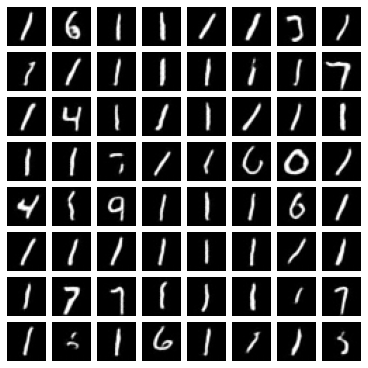

Epoch 30  Loss 1.382
Epoch 31  Loss 1.305
Epoch 32  Loss 1.458
Epoch 33  Loss 1.422
Epoch 34  Loss 1.382
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


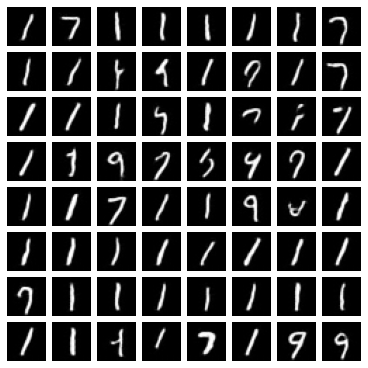

Epoch 35  Loss 1.334
Epoch 36  Loss 1.456
Epoch 37  Loss 1.454
Epoch 38  Loss 1.380
Epoch 39  Loss 1.348
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


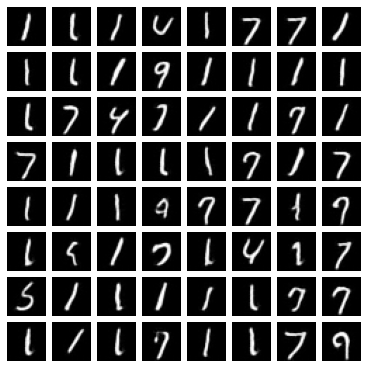

Epoch 40  Loss 1.346
Epoch 41  Loss 1.359
Epoch 42  Loss 1.298
Epoch 43  Loss 1.591
Epoch 44  Loss 1.385
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


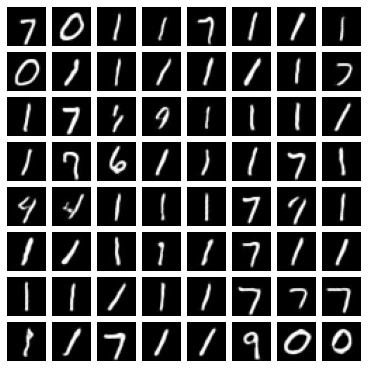

Epoch 45  Loss 1.402
Epoch 46  Loss 1.317
Epoch 47  Loss 1.318
Epoch 48  Loss 1.298
Epoch 49  Loss 1.213
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


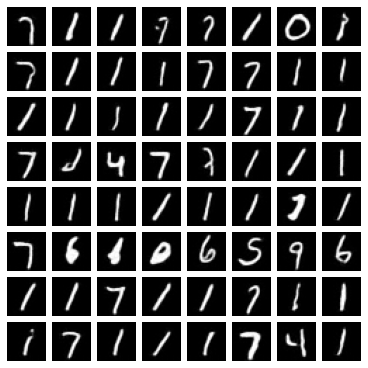

Epoch 50  Loss 1.645
Epoch 51  Loss 1.424
Epoch 52  Loss 1.293
Epoch 53  Loss 1.419
Epoch 54  Loss 1.318
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


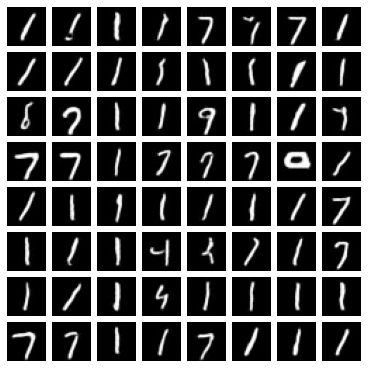

Epoch 55  Loss 1.300
Epoch 56  Loss 1.272
Epoch 57  Loss 1.326
Epoch 58  Loss 1.251
Epoch 59  Loss 1.185
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


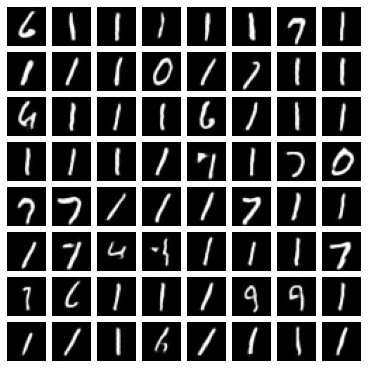

Epoch 60  Loss 1.342
Epoch 61  Loss 1.531
Epoch 62  Loss 1.318
Epoch 63  Loss 1.277
Epoch 64  Loss 1.281
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


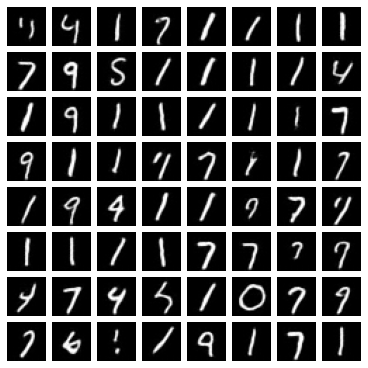

Epoch 65  Loss 1.438
Epoch 66  Loss 1.199
Epoch 67  Loss 1.251
Epoch 68  Loss 1.196
Epoch 69  Loss 1.216
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


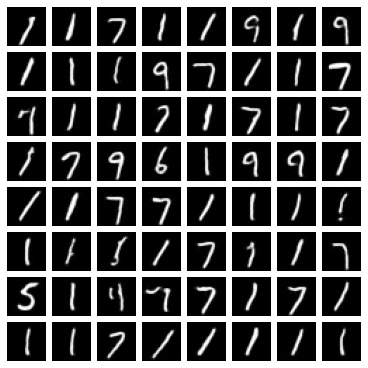

Epoch 70  Loss 1.379
Epoch 71  Loss 1.330
Epoch 72  Loss 1.310
Epoch 73  Loss 1.328
Epoch 74  Loss 1.153
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


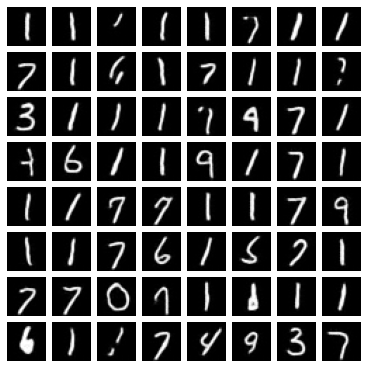

Epoch 75  Loss 1.431
Epoch 76  Loss 1.269
Epoch 77  Loss 1.247
Epoch 78  Loss 1.300
Epoch 79  Loss 1.205
torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


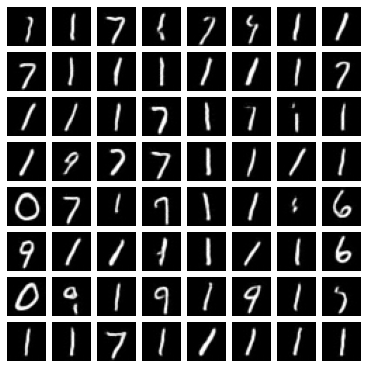

In [732]:
epochs = 500
optimizer = torch.optim.Adam(denoise_fn.parameters(), lr=1e-3)
plt_ = 1
for epoch in range(epochs):
    denoise_fn.train()
    for batch_idx, (indices) in enumerate(train_indices):
        indices = indices.float().cuda()
        indices = indices.unsqueeze(dim=1)
        loss = abdiff.train_iter(indices)
        loss = loss['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch {}  Loss {:.3f}".format(epoch, loss.item()))\
    
    if plt_ == 1 and (epoch+1)%5 == 0:
        denoise_fn.eval() 
        sample = (abdiff.sample(sample_steps=256)).reshape(64,7,7)
        with torch.inference_mode():
            z = model.vq_layer.quantize(sample.cuda())
            #print(z.shape)
            z = z.permute(0, 3, 1, 2).contiguous()
            #print(z.shape)
            # torch.Size([128, 16, 7, 7, 16])
            pred = model.decoder(z)

        generated_samples = np.array(np.clip((pred + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
        generated_samples = generated_samples.reshape(8, 8, 28, 28)

        fig = plt.figure(figsize=(5, 5), constrained_layout=True)
        gs = fig.add_gridspec(8, 8)
        for n_row in range(8):
            for n_col in range(8):
                f_ax = fig.add_subplot(gs[n_row, n_col])
                f_ax.imshow(generated_samples[n_row, n_col], cmap="gray")
                f_ax.axis("off")
        plt.show()
        

torch.Size([64, 7, 7, 16])
torch.Size([64, 16, 7, 7])


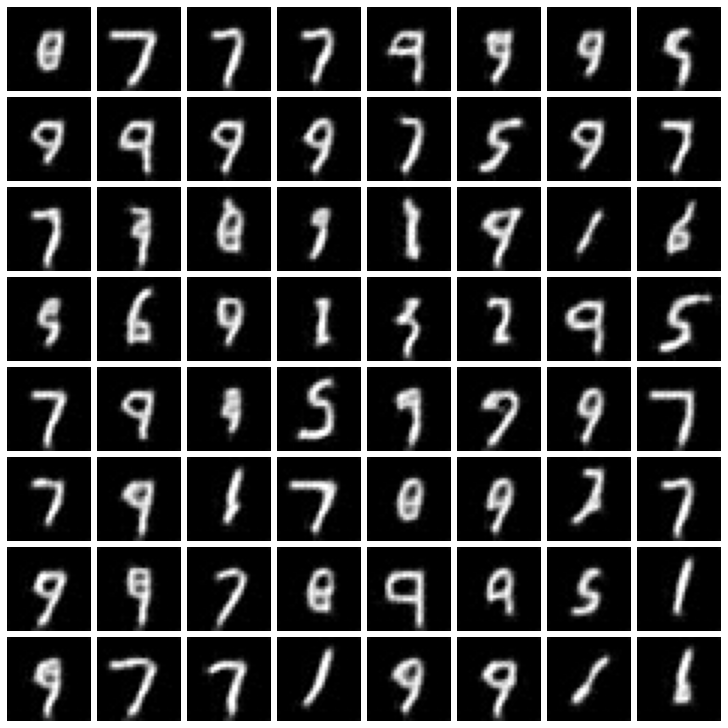

In [ ]:
denoise_fn.eval() 
sample = (abdiff.sample(sample_steps=256)).reshape(64,7,7)
with torch.inference_mode():
    z = model.vq_layer.quantize(sample.cuda())
    print(z.shape)
    z = z.permute(0, 3, 1, 2).contiguous()
    print(z.shape)
    # torch.Size([128, 16, 7, 7, 16])
    pred = model.decoder(z)

generated_samples = np.array(np.clip((pred + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
generated_samples = generated_samples.reshape(8, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_samples[n_row, n_col], cmap="gray")
        f_ax.axis("off")
plt.show()